# 章節 15：維度處理

## 15.4 隨機取樣

有兩種方式從 Dirichlet 分佈隨機取樣。一種是用邊際 Beta 分佈，但在這種情況下你一次取一個種類並且縮放其他的種類，讓他們加起來為 1。(參考 http://en.wikipedia.org/wiki/Dirichlet_distribution#Random_number_generation)。

另一個比較不明顯但比較快的方法是從 Gamma 分佈取樣並且用加總正規化：

<pre>
# class Dirichlet
    def Random(self):
        p = numpy.random.gamma(self.params)
        return p / p.sum()
</pre>

現在我們可以看一些結果。這邊是產生 n 的後驗分佈的程式碼：
<pre>
def DistOfN(self):
    pmf = thinkbayes.Pmf()
    for hypo, prob in self.Items():
        pmf.Set(hypo.n, prob)
    return pmf
</pre>

DistOfN 迭代所有上層假設的 n 並且累積所有假設的機率。

0.8416209365048308

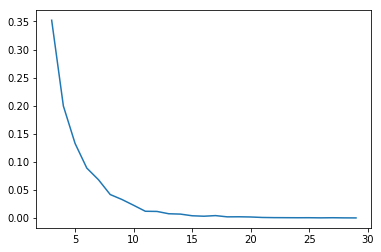

In [66]:
import thinkbayes as tb
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)


def plot_dist(dist, c=None):
    x, y = zip(*sorted(dist.Items()))
    plt.plot(x, y, c=c)

    
class Species(tb.Suite):

    def __init__(self, ns):
        # ns: 一序列可能的物種數量
        
        # 產生一序列的 Dirichlet 物件
        hypos = [tb.Dirichlet(n) for n in ns]
        
        tb.Suite.__init__(self, hypos)

        
    def Update(self, data):
        # 更新下層的每個假設
        for hypo in self.Values():
            if hypo.n < len(data):
                continue
                
            hypo.Update(data)
        
        # 更新上層假設
        tb.Suite.Update(self, data)
                               
    
    def Likelihood(self, data, hypo):
        # data: 一序列觀察到的次數

        # hypo 是一個 Dirichlet 物件
        dirichlet = hypo
        like = 0
        for i in range(100):

            # 呼叫 Dirichlet.Likelihood 方法 1000 次，並且加總
            like += dirichlet.Likelihood(data)

        return like
    
    
    def DistOfN(self):
        pmf = tb.Pmf()
        for hypo, prob in self.Items():
            pmf.Set(hypo.n, prob)
        return pmf
    

ns = range(3, 30)
suite = Species(ns)
suite.Update([3, 2, 1])


pmf = suite.DistOfN()

plot_dist(pmf)
cdf = pmf.MakeCdf()
cdf.Prob(7)

上圖為後驗分佈的結果，3 到 7 種物種最有可能（CDF 大約為 84%）;在 7 種物種之後就下降很快。29 種物種的可能性幾乎可以不考慮；如果我們選一個更高的物種上限，也會得到差不多的結果。

我們的 n 物種的先驗分佈是用均勻分佈。如果我們的有更多關於物種數量的背景知識，可能可以選擇不同的先驗分佈。